In [25]:
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy.interpolate  # used for interpolation
import pyproj  # used for coordinate transformations~
import math
from thetis import *
from firedrake.pyplot import triplot, tricontourf, quiver
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="firedrake.interpolation")
warnings.filterwarnings("ignore", category=FutureWarning, module="pyproj.transform")

In [26]:
# Create mesh, define mesh elements and plot
lx = 10e3
ly = 10e3
nx = 20
ny = 20
mesh2d = RectangleMesh(nx, ny, lx, ly)

P1_2d = FunctionSpace(mesh2d, 'CG', 1)
# fig, ax = plt.subplots(figsize=(5,5))
# triplot(mesh2d, axes=ax);
# ax.legend(loc= 'right', bbox_to_anchor=(1.2,0.5))

In [27]:
# Define Baythymetry
bathymetry_2d = Function(P1_2d, name='Bathymetry')
x = SpatialCoordinate(mesh2d)
bathymetry_expr = 20.0 * (x[0] / lx)
bathymetry_2d.interpolate(bathymetry_expr)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7053a154d910>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 390)), 909)

In [28]:
 # Plot the bathymetry data
# fig, ax = plt.subplots(figsize=(8, 6))
# contour = tricontourf(bathymetry_2d, axes=ax, cmap=matplotlib.cm.viridis, levels=50)
# cbar = plt.colorbar(contour, ax=ax)
# cbar.set_label('Bathymetry Depth (m)')
# ax.set_title('Bathymetry Contour')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')


In [29]:
# Define Initial Tsunami wave
elev_init = Function(P1_2d)
wave_height = 5.0  # Height of the wave in meters
elev_expr = wave_height * exp(-((x[0] - lx + 50) ** 2) / (2 * 100 ** 2))  # Gaussian wave
elev_init.interpolate(elev_expr)


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7053a154d910>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 390)), 916)

In [30]:
P1v_2d = VectorFunctionSpace(mesh2d, 'CG', 1)

vel_init = Function(P1v_2d)
velocity_expr = as_vector((0.00001,0.0))
vel_init.interpolate(velocity_expr)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7053a154d910>, VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 390)), 922)

In [31]:
# plt.figure(figsize=(6, 6))
# ax = plt.gca()
# tricontourf(elev_init, axes=ax, cmap=matplotlib.cm.coolwarm, levels=50);

In [32]:
# Define solver options
# h_viscosity = Function(P1_2d).interpolate(conditional(le(x[0], 50), 50, 50))

solver_obj = solver2d.FlowSolver2d(mesh2d, bathymetry_2d)
options = solver_obj.options
options.simulation_export_time = 360  # Export interval in seconds
options.simulation_end_time = 3600#3600*2   # Total duration in seconds
# options.quadratic_drag_coefficient = Constant(5.)
# options.horizontal_viscosity = h_viscosity
options.swe_timestepper_type = 'CrankNicolson'
options.timestep = 5
options.output_directory = 'notebook_outputs'
options.fields_to_export = ['elev_2d', 'uv_2d']
options.fields_to_export_hdf5 = ['elev_2d', 'uv_2d']
options.use_wetting_and_drying = True
#options.horizontal_viscosity = Constant(1)
options.manning_drag_coefficient = Constant(0.025)


In [33]:
left_bnd_id = 1
right_bnd_id = 2
bot_bnd_id = 3
top_bnd_id = 4
swe_bnd = {}
swe_bnd[right_bnd_id] = {'elev': Constant(0.0),}
swe_bnd[top_bnd_id] = {'elev': Constant(0.0)}
swe_bnd[bot_bnd_id] = {'elev': Constant(0.0),}

solver_obj.bnd_functions['shallow_water'] = swe_bnd

In [34]:
solver_obj.assign_initial_conditions(elev=elev_init, uv=vel_init)
#solver_obj.create_equations()


Using constant wetting and drying parameter (value 0.50)
Element family: dg-dg, degree: 1
2D cell type: triangle
2D mesh: 441 vertices, 800 elements
Horizontal element size: 353.55 ... 353.55 m
Number of 2D elevation DOFs: 2400
Number of 2D velocity DOFs: 4800
Number of cores: 1
Elevation DOFs per core: ~2400.0
dt = 5
Using time integrator: CrankNicolson


In [35]:
solver_obj.iterate()

  exp  iter            time       eta norm         u norm   Tcpu
    0     0            0.00      5696.6223         0.1000   0.00
    1    72          360.00      1125.6850      1050.5482   7.98
    2   144          720.00       765.4598      1062.3827   6.69
    3   216         1080.00       491.4404      1178.3598   7.25
    4   288         1440.00       249.9491       304.3959   7.77
    5   360         1800.00       114.5689       248.3509   7.26
    6   432         2160.00       111.0927       189.9436   7.02
    7   504         2520.00       118.0340       157.8076   7.05
    8   576         2880.00       117.8947       162.9491   6.92
    9   648         3240.00       109.7524       190.6831   6.70
   10   720         3600.00       103.8654       224.9650   6.92


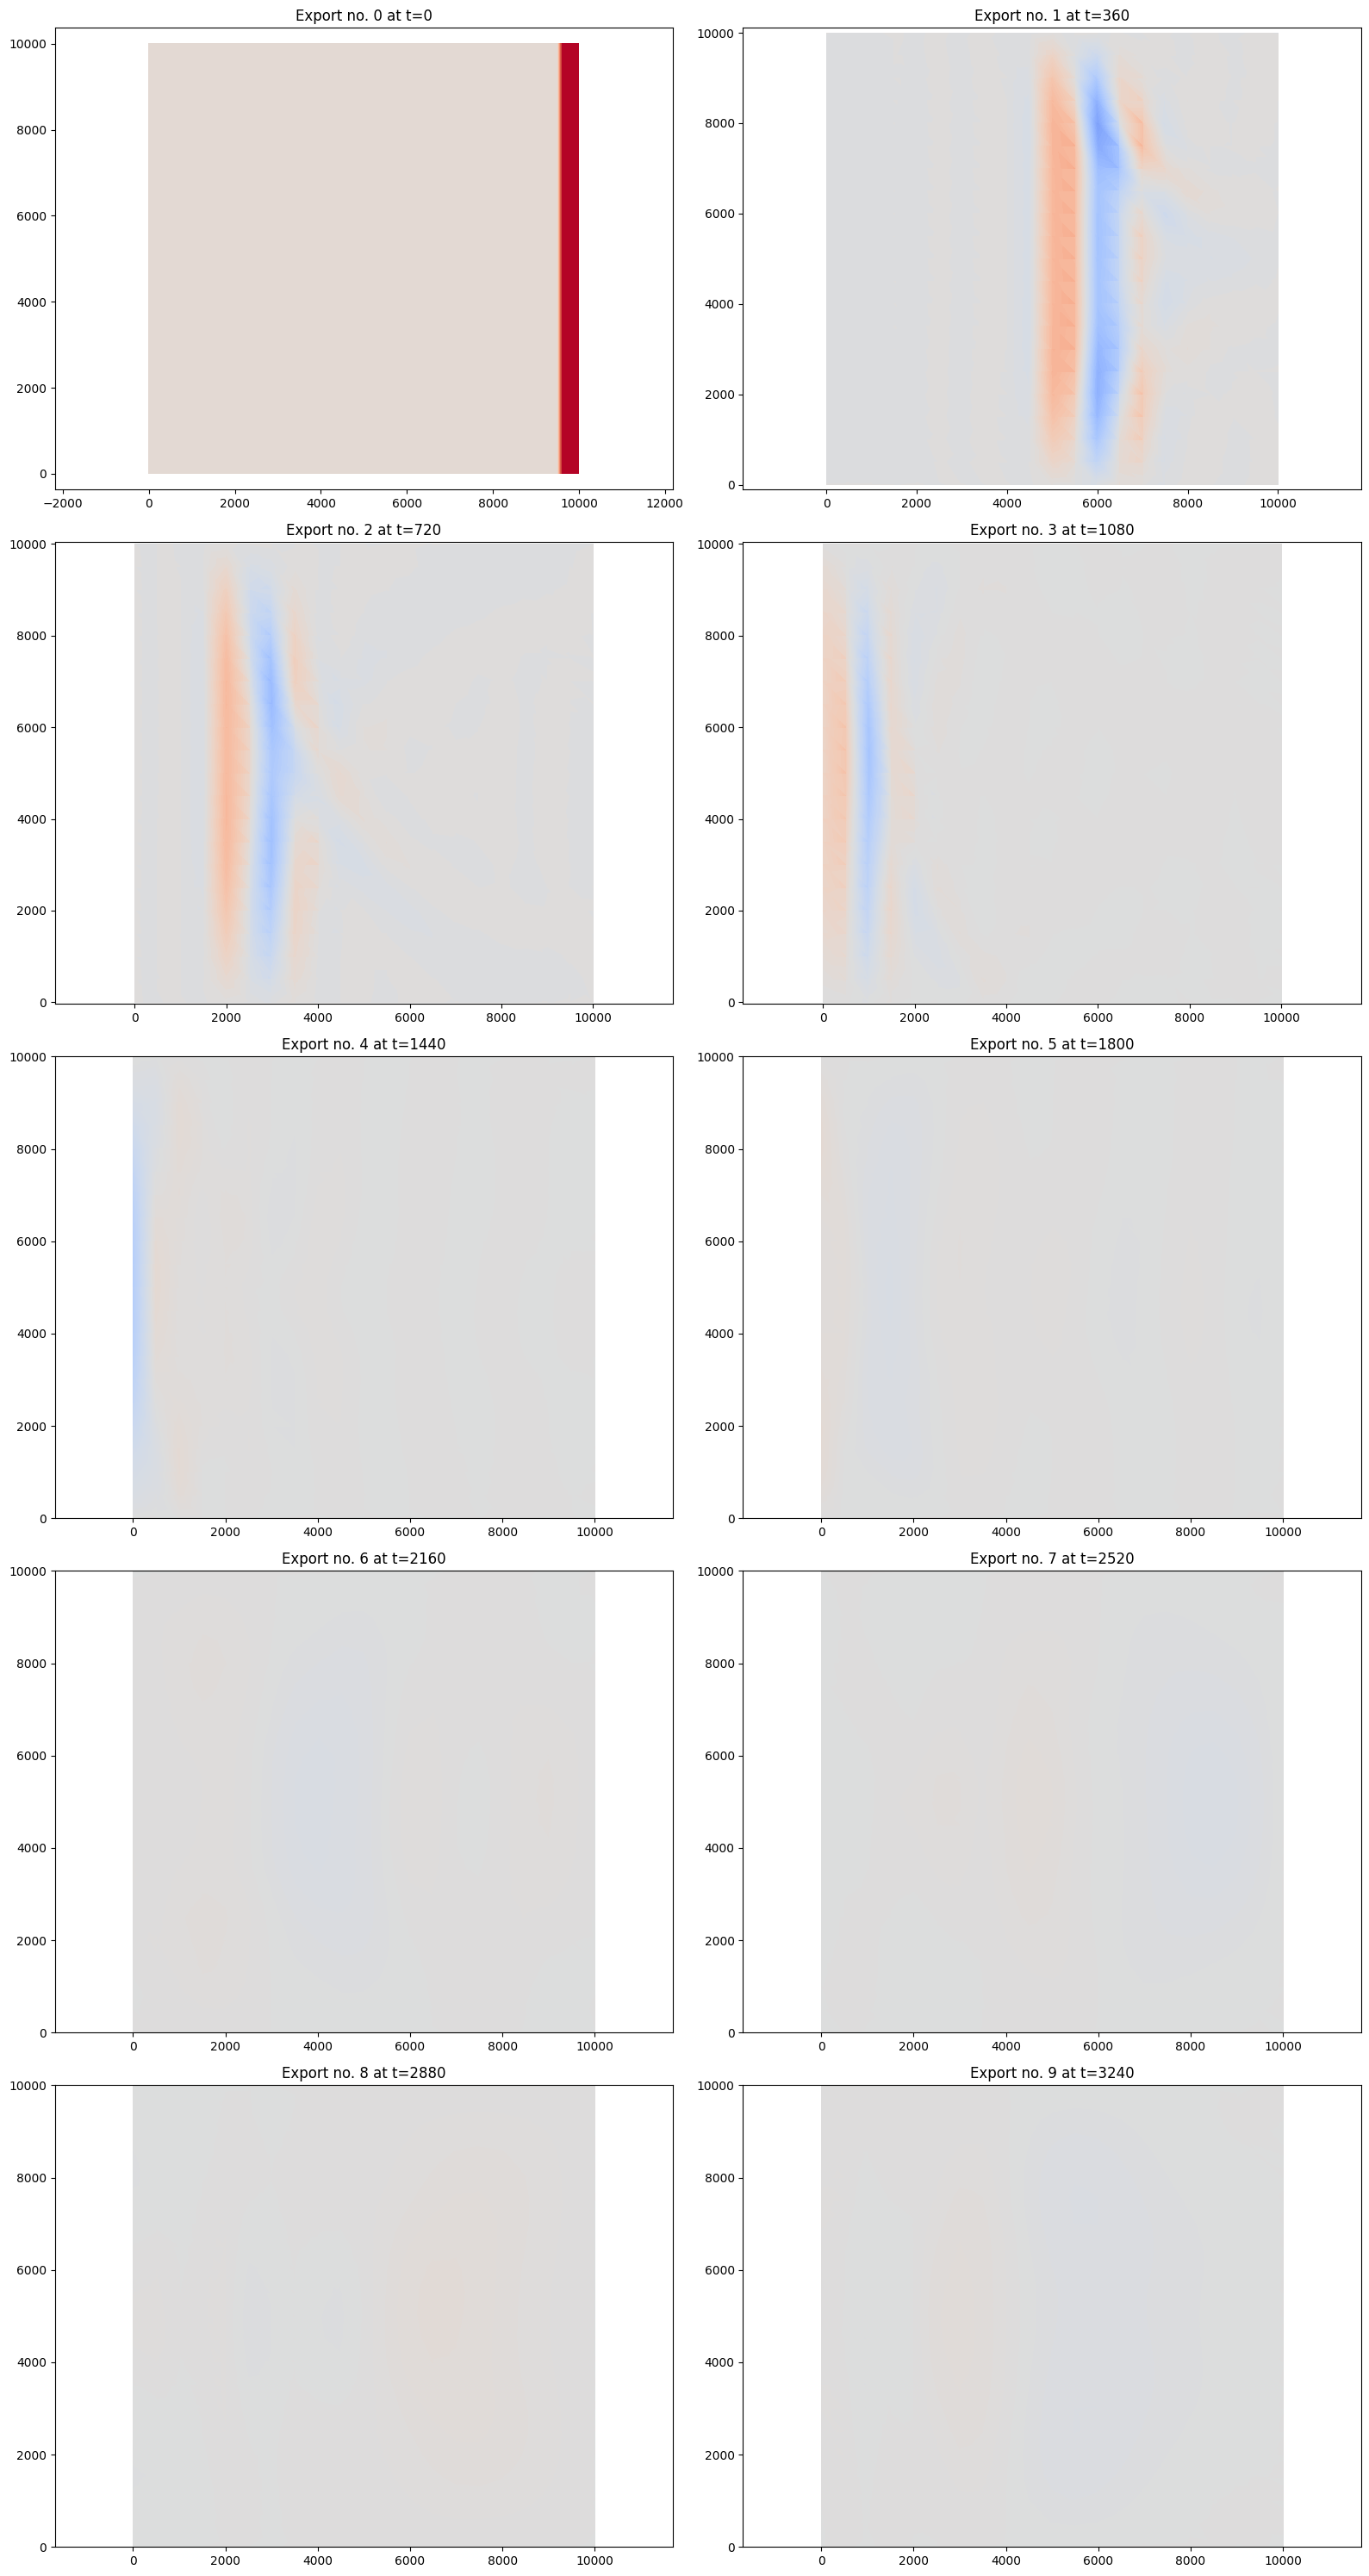

In [36]:
elev = Function(solver_obj.function_spaces.H_2d, name='elev_2d')
uv = Function(solver_obj.function_spaces.U_2d, name='uv_2d')

last_idx = solver_obj.i_export
nrows = math.ceil(last_idx/2)
fig, axes  = plt.subplots(nrows, 2, figsize=(16, 6*nrows))

for idx, ax in enumerate(axes.flatten()):
    filename =  os.path.join(options.output_directory, 'hdf5','Elevation2d_%05d' % idx)
    with CheckpointFile(filename + '.h5', 'r') as CF:
        mesh2d = CF.load_mesh()
        elev = CF.load_function(mesh2d, name="elev_2d")
    CF.close()
    # by specifying cmap=None above, we avoid displaying a colorbar
    tricontourf(elev, axes=ax, cmap=matplotlib.cm.coolwarm, levels=50)
    # Firedrake sets an automatic colorbar range which therefore changes per timestep
    # instead, we want to fix it:
    cbar = ax.collections[-1].set_clim(-1, 1)
    # we do want to set an appropriate colormap
    cbar = ax.collections[-1].set_cmap(matplotlib.cm.coolwarm)
    ax.axis('equal')
    ax.title.set_text('Export no. %d at t=%.0f' % (idx, options.simulation_export_time*idx))
    plt.tight_layout()